<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Stochastic_Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We load the neccessary libraries, specifiy the domain $z \in [0,1]$ and the differentiation matrices $D = d/dz$ and $L = d^2/dz^2$.

In [83]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

ε    = 1e-12
Npts = 64

z = np.linspace(0+ε,1-ε,Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dF}{dz} &= -\frac{d b}{d z} Q, \\
\frac{dQ}{dz} &= \frac{Q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{Q^2} F, \\
\end{align*}
where $F(z)$ and $Q(z)$ are the horizontally averaged (steady) buoyancy flux and volume flux respectively. This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the dimensionless turbulence production coefficient $\delta < 0$. These equations are implemented below.

In [84]:
@nb.njit()
def plume_eqns(z,X,z_i,dbdz_i,plume_type,δ=-0.25):

    """
    F,Q  = X
    """

    dX    = 0*X
    if plume_type == "Rise":
      dX[0] = -np.interp(z,z_i,dbdz_i)*X[1];
    elif plume_type == "Sink":
      dX[0] = -np.interp(1-z,z_i,dbdz_i)*X[1];

    dX[1] = X[1]/z + ((3**4)/(2**6))*( ((z**4)*(δ**4)*(np.pi**2))/(X[1]**2) )*X[0]
    return dX;

To solve these equations we first set up an ode solver using scipy, which for a rising plume takes as initial conditions
\begin{align*}
Q(z=0) &= Q_0, \\
F(z=0) &= P_{F|Q}(f|q=Q_0,z=0) = \mathcal{N}(\mu=F_0,\sigma^2)
\end{align*}
where the buoyancy flux is drawn from a normal distribution centered around $F_0$ with variance ??. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$, which requires making the transform $z \to 1-z$ and then integrating from $z=1 \to 0$ until $F=0$. \\

As $F(z=0,1)$ is given by a distribution, we make use of a Monte-Carlo approach in order to obtain the average solution. This consists of running whereby a large ensemble of initial conditions and then averaging over the ensemble of solutions.

In [85]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;

def N(μ=0,σ=.1,samples = 10**2):

  """
  Generate N_samples from a Normal distribution

  N(μ,σ2)

  of mean μ and standard deviation σ.

  """

  return np.random.default_rng().normal(loc=μ,scale=σ,size=samples)

def Plume_Solve(F0,dbdz):

    def event(t,y,*args): return y[0];
    event.terminal = True;
    event.positive = 0

    if F0 < 0:
      plume_type = "Sink"
    elif F0 >0:
      plume_type = "Rise"

    # Solver
    sol  = solve_ivp(fun=plume_eqns,t_span=[z[0],z[-1]], y0=[abs(F0),ε], t_eval=z,args=(z,dbdz,plume_type),events=event)

    F = 0.*z;
    Q = 0.*z;
    if F0 > 0.:
      F[0:len(sol.y[0])] = sol.y[0]
      Q[0:len(sol.y[1])] = sol.y[1]
    elif F0 < 0.:
      F[Npts-len(sol.y[0]):] =     sol.y[0][::-1]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][::-1]

    return F,Q

def Plume_Solve_Distribution(F0,Nsq,samples = 10**2):

  # Get the samples
  std_dev = (abs(F0)/10.) # 10% of the mean
  μ       = F0
  F_0     = N(μ=μ,σ=std_dev,samples=samples)

  # print('Checking distribution mu,std_dev=',abs(μ - np.mean(F_0)),abs(std_dev - np.std(F_0) ))
  # plt.hist(F_0, bins=30, density=True)
  # plt.show()

  # Containers for the solution
  Q = 0*z
  F = 0*z

  for f_0 in F_0:
    Fi,Qi  = Plume_Solve(f_0,Nsq)
    F+=Fi; Q+=Qi

  F /=samples
  Q /=samples

  return F,Q

Generate rising and descending plumes

In [ ]:
# Initial conditions
Nsq    = 1*(z/z)
Plumes = {'F1':.1,'F2':-.1}
Plumes = {'F1':.07,'F2':-.1,'F3':0.03}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

We now repeat this process except for initial conditions drawn from a normal distribution of mean $F_i$ and standard deviation 10% of the mean.

F1 0.1


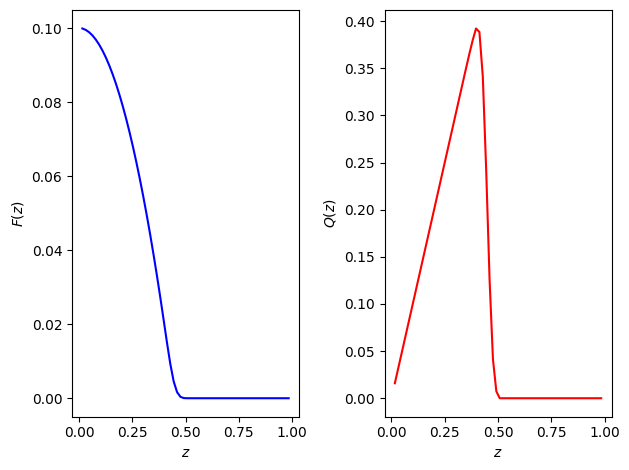

F2 -0.1


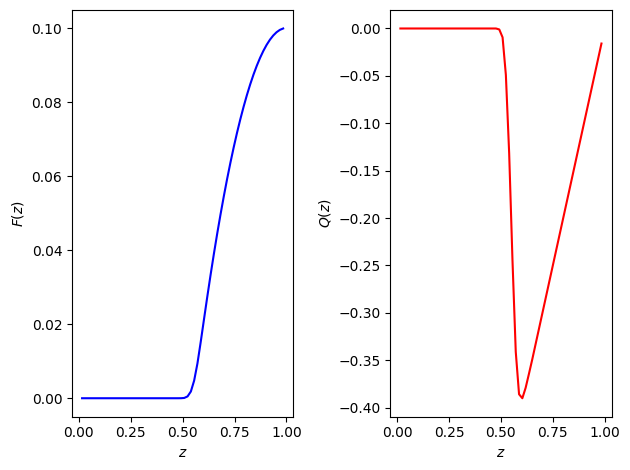

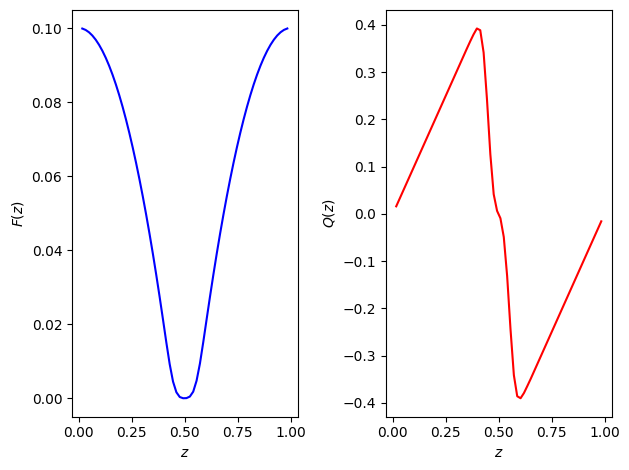

In [95]:
# Initial conditions
Nsq    = 1*(z/z)
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Distribution(F_value,Nsq,samples = 10**3)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \sigma \frac{\partial^2 b}{\partial z^2},
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
and $\sigma$ a regularising diffusion. To do solve we implement the advection diffusion equation with and without a regularising diffusion for buoyancy $b(z,t)$ as below

In [87]:
def step_buoyancy(w,b,σ=.1,dt=1e-03,A_inv = None, B = None):

    """
    Step forward using one time-step

    if σ > 0:
    Crank-Nicolson
    elif σ == 0
    Euler-Explicit

    returns b(z,t_n+1)
    """

    if σ > 0:

      if (A_inv is None) and (B is None):
        A = (I/dt - .5*σ*L)
        B = (I/dt + .5*σ*L)
        return np.linalg.solve(A,B@b - w*(D@b) )
      else:
        return A_inv@( B@b - w*(D@b) )

    elif σ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*dt)/dz > 1.:
        dt *=0.5

      return b - dt*w*(D@b)

With a solver developed for the plume equations and for the 1D buoyancy equations we now link these routines together to establish the background stratification profile for a given set of plume sources and sinks. We consider the case of two opposing plumes of equal strength. \\

We first specify initial conditions for the rising plume
\begin{align}
  F_1(z=0) &= 1, \\
  Q_1(z=0) &= 0, \\
\end{align}
the sinking plume
\begin{align}
  F_2(z=1) &=-1, \\
  Q_2(z=1) &= 0, \\
\end{align}
and the initial stratification
\begin{equation}
  db/dz(z,t_0=0) = 1.
\end{equation}
Using these boundary conditions we then:
- Solve the plume equations using $db/dz(z,t_n)$ for each of the plumes to obtain $Q_i^n$
- Compute $\bar{w}(z,t_n)$ from the sum of the plumes' volume fluxes $Q_i^n$
- Timestep the 1D buoyancy equation forward from $t_n \to t_n + dt$ to update $db/dz(z,t_n)$ \\

This process is repeated until the residual error
\begin{equation}
  || db^{n+1}/dz - db^{n}/dz ||_2/||db^{n}/dz || < \text{tol},
\end{equation}
falls below a user prescribed tolerance.

Iteration i = 1000, Residual error r_i = 3.900232e-04 



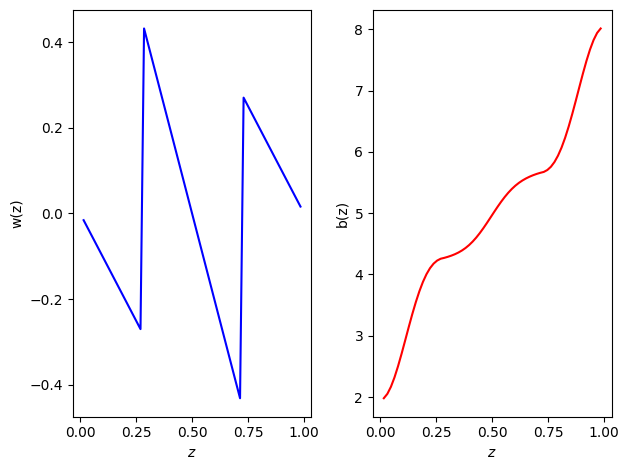

Iteration i = 2000, Residual error r_i = 1.889197e-04 



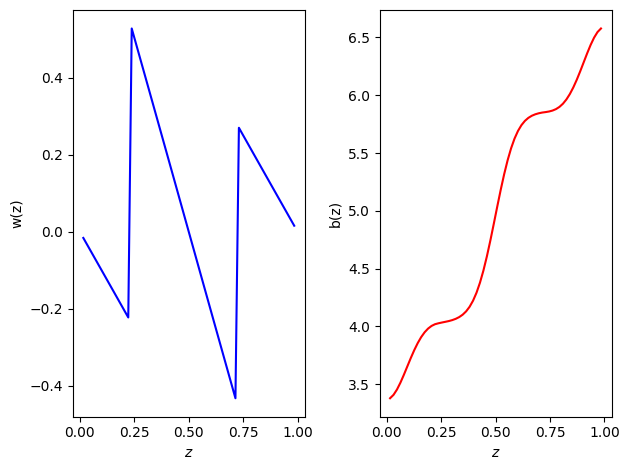

Iteration i = 3000, Residual error r_i = 5.771119e-05 



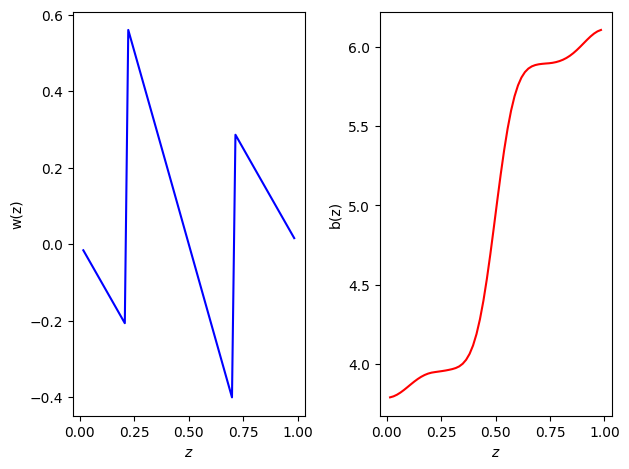

Iteration i = 4000, Residual error r_i = 2.704298e-05 



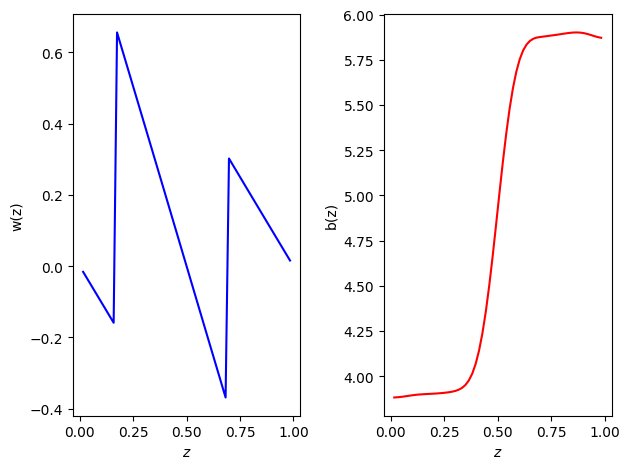

Iteration i = 5000, Residual error r_i = 6.838696e-06 



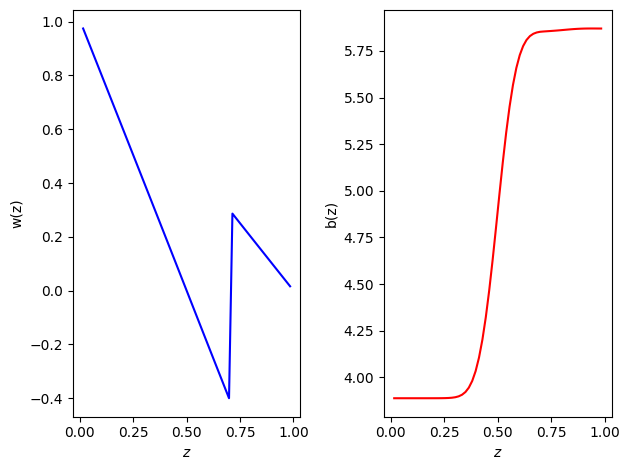

Iteration i = 6000, Residual error r_i = 1.927441e-06 



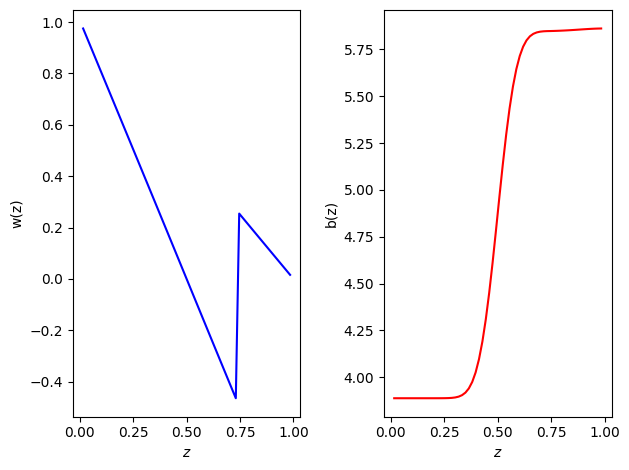

Iteration i = 7000, Residual error r_i = 1.045660e-06 



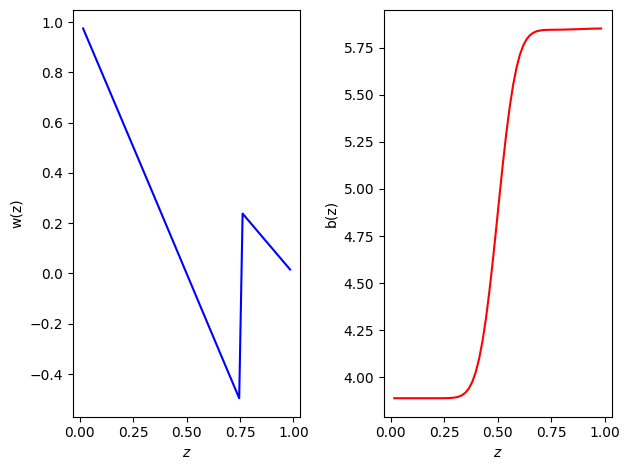

Iteration i = 8000, Residual error r_i = 4.610105e-07 



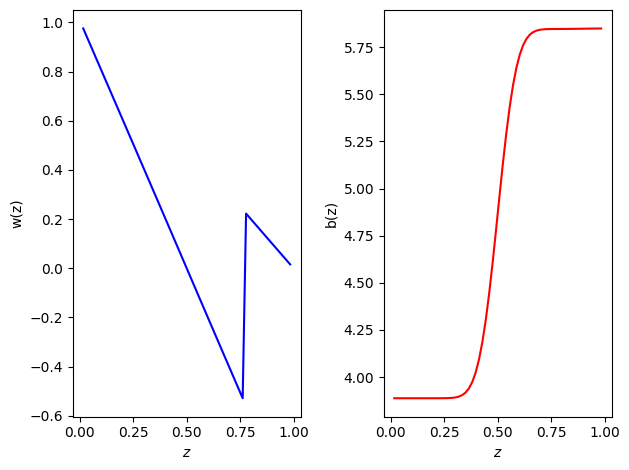

Iteration i = 9000, Residual error r_i = 1.754789e-07 



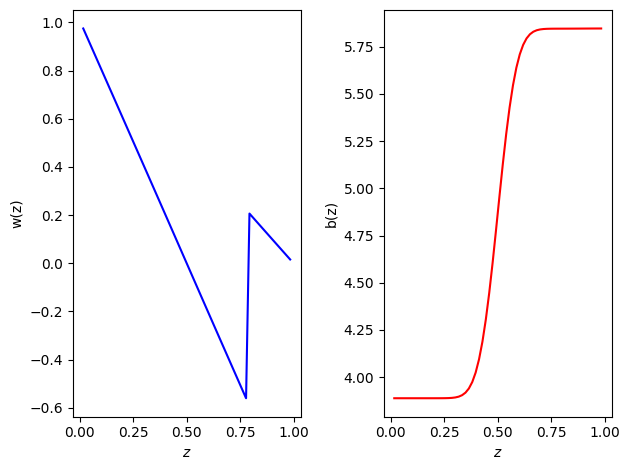

Iteration i = 10000, Residual error r_i = 1.826980e-07 



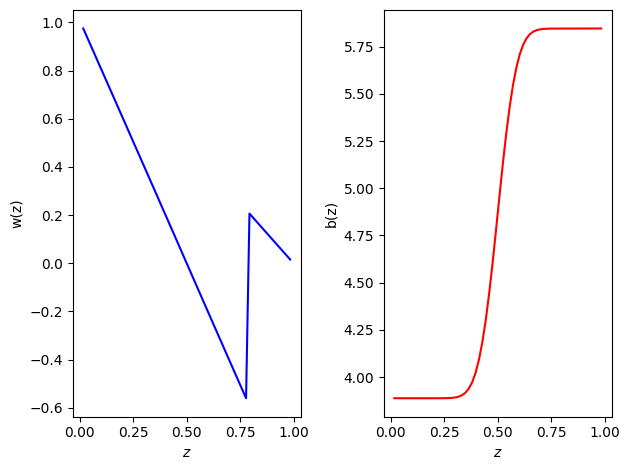

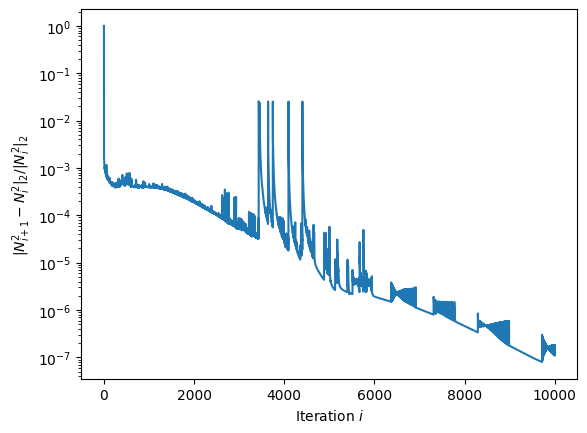

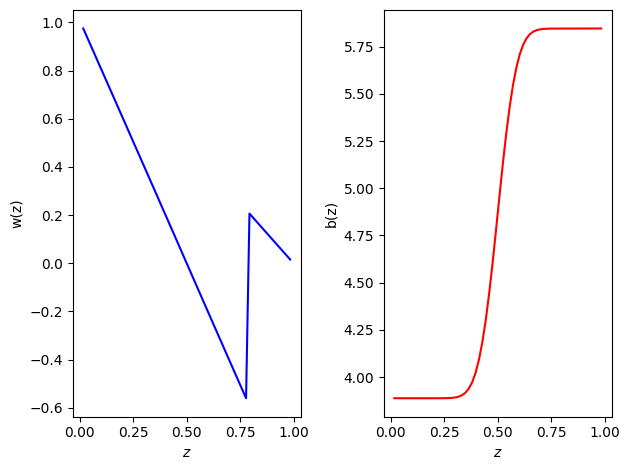

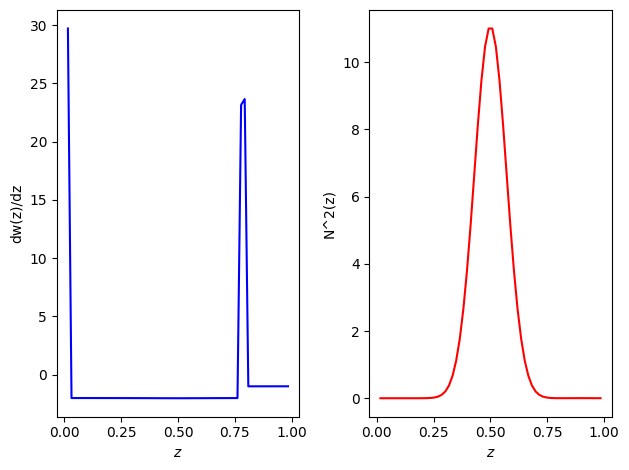

In [92]:
# Sources and IC
b      = 10*z;
Nsq    = D@b;
Plumes = {'F1':1,'F2':-1}
Area   = 1.0

σ     = 1e-02
dt    = 1e-03
A_inv = np.linalg.inv(I/dt - .5*σ*L)
B     = (I/dt + .5*σ*L)

Error = [1.0];
iter  = 0;
while (iter < 10*(10**3)): #(Error[-1] > 1e-03) or

  # (1) solve plume equations
  w = 0*z
  for F_key,F_value in Plumes.items():

    # Fixed buoyancy flux
    Q_i= Plume_Solve(F_value,Nsq)[1]

    # Distribution of buoyancy flux- Monte-Carlo
    #Q_i= Plume_Solve_Distribution(F_value,Nsq,samples = 10)[1]

    # Distribution of buoyancy flux - Fokker-Planck
    ##Q_i= Plume_Solve_Distribution(F_value,Nsq,samples = 10**2)[1]

    w -= Q_i/Area

  # (2) step db/dt forward
  b = step_buoyancy(w,b,σ=σ,dt=dt,A_inv=A_inv,B=B)

  # (3) update N^2 & check converged
  Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
  Nsq   = D@b;
  iter += 1.

  if iter%1000 ==0:
    print('Iteration i = %d, Residual error r_i = %e \n'%(iter,Error[-1]))
    Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')
Plot_F_and_Q(D@w,Nsq,label_f='dw(z)/dz',label_q='N^2(z)')